In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
%cd /gdrive/'My Drive'/EVA2019

/gdrive/My Drive/EVA2019


In [0]:
# !wget https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt

In [0]:
# !cat imagenet1000_clsidx_to_labels.txt
import re
id_to_label={int(re.sub(r'[{}]','',i.split(':')[0])):i.split(':')[1][:-3] for i in open('imagenet1000_clsidx_to_labels.txt')}

In [0]:
import matplotlib.pyplot as plt


In [5]:
from skimage import io
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys
import numpy as np

model = ResNet50(weights='imagenet')



Using TensorFlow backend.
W0808 16:32:31.980360 140115732285312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0808 16:32:31.997367 140115732285312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0808 16:32:32.002527 140115732285312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0808 16:32:32.026826 140115732285312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session inste

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [0]:
def get_predictions(img_path):

  
  img = io.imread(img_path)
  x =cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)
  plt.imshow(img)
  print(id_to_label[np.argmax(preds)])



In [13]:
!display model.png

/bin/bash: display: command not found


 'Egyptian cat


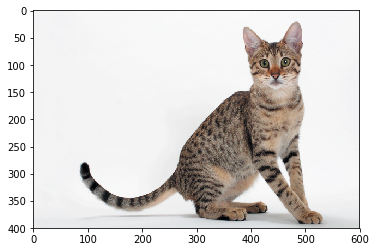

In [7]:
get_predictions(img_path = 'cat1.jpg')

 'sunglasses, dark glasses, shades


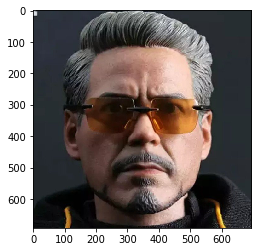

In [8]:
get_predictions(img_path = 'glasses.jpg')

## Gradcam Visualizations

In [0]:
def visualize_GradCam(img_path,img,model,layer_name='conv2d_139',label=None):

  if label:
    class_idx=label
    x=img
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    print('Visualizing \nid= {} \nlabel= {} \non {}'.format(class_idx,id_to_label[class_idx],img_path))
  else:
    x=img
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    preds = model.predict(x)
    class_idx = np.argmax(preds)
    print('model predicted\n id= {} \nlabel= {}'.format(class_idx,id_to_label[class_idx]))
  # print(id_to_label[class_idx])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(layer_name)
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(conv_layer_output_value.shape[-1]):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)    


  heatmap = cv2.resize(heatmap, (224, 224))
  
  
  heatmap = np.uint8(255*heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  
 
  superimposed_img = cv2.addWeighted(img, 0.7, heatmap, 0.5, 0)
  
  return heatmap,superimposed_img

In [0]:
def show_gradcam(img_path,model,layer_name='conv2d_139',label=None):
  
  img = io.imread(img_path)
  img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

  heatmap,superimposed_img=visualize_GradCam(img_path,img,model,layer_name,label)
  images = []
  images.append(img)
  images.append(heatmap)

  images.append(superimposed_img)
  titles = ['Original Image','HeatMap','gradCam Image']
  f = plt.figure(figsize=(15,15))

  for i in range(len(images)):
      plt.subplot(1,3,i+1),plt.imshow(images[i])
      plt.title(titles[i])
      plt.xticks([]),plt.yticks([])

  plt.show()

show_gradcam function() accepts 4 parameters img_path,model,layer_name and label .
```
-if we dont specify the label it will predict the output of image get the label and then apply gradcam on it.
-else it will take the label into consideration take outputs from that and then operate gradcam on it.. 
```

## Taking the gradcam visualizations from res5c_branch2c 

model predicted
 id= 285 
label=  'Egyptian cat


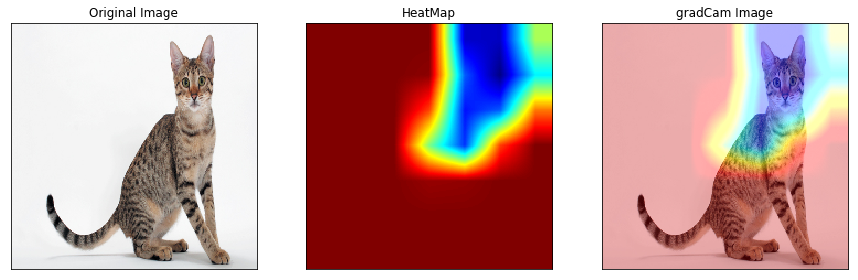

In [0]:
show_gradcam('cat1.jpg',model,layer_name='res5c_branch2c')

model predicted
 id= 837 
label=  'sunglasses, dark glasses, shades


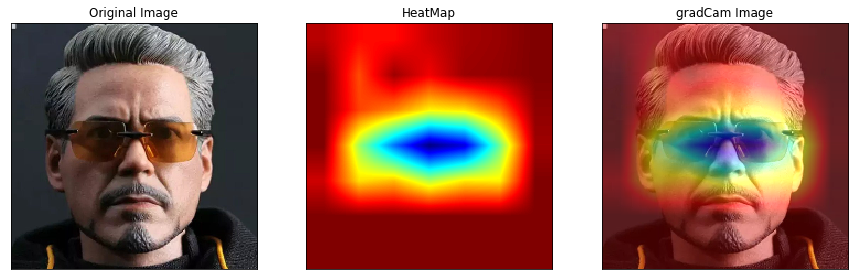

In [0]:
show_gradcam('glasses.jpg',model,layer_name='res5c_branch2c')

Visualizing 
id= 837 
label=  'sunglasses, dark glasses, shades 
on glasses.jpg


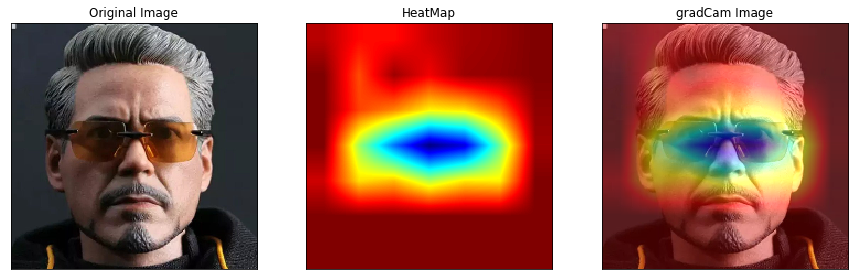

In [0]:
show_gradcam('glasses.jpg',model,layer_name='res5c_branch2c',label=837)

### Visualize  sunglasses, dark glasses, shades on cat

Visualizing 
id= 837 
label=  'sunglasses, dark glasses, shades 
on cat1.jpg


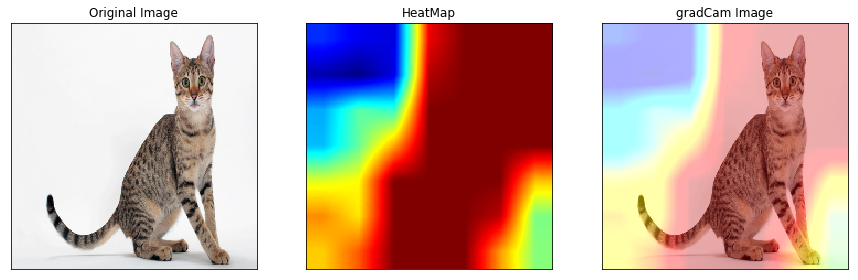

In [0]:
show_gradcam('cat1.jpg',model,layer_name='res5c_branch2c',label=837)

### Visualizing sunglasses on pug

Visualizing 
id= 837 
label=  'sunglasses, dark glasses, shades 
on pug-690566_1920.jpg


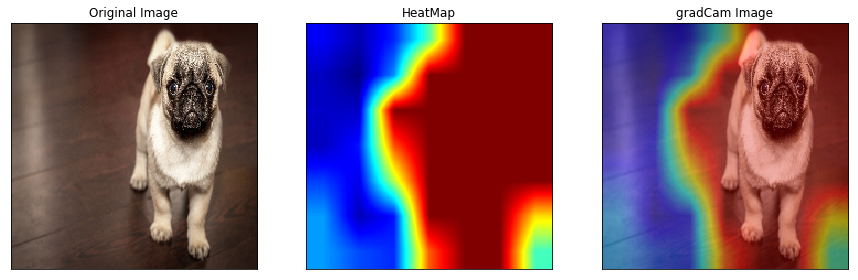

In [0]:
show_gradcam('pug-690566_1920.jpg',model,layer_name='res5c_branch2c',label=837)

model predicted
 id= 254 
label=  'pug, pug-dog


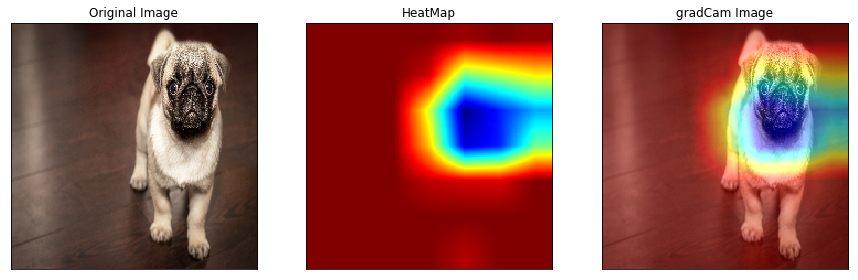

In [0]:
show_gradcam('pug-690566_1920.jpg',model,layer_name='res5c_branch2c')

## Taking the gradcam visualizations from res5c_branch2b 

model predicted
 id= 285 
label=  'Egyptian cat


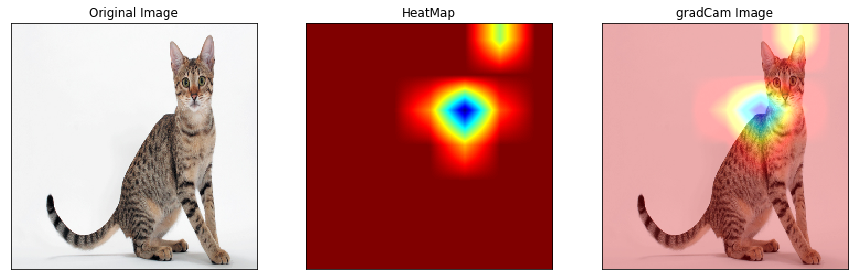

In [15]:
show_gradcam('cat1.jpg',model,layer_name='res5c_branch2b')

Visualizing 
id= 285 
label=  'Egyptian cat 
on cat1.jpg


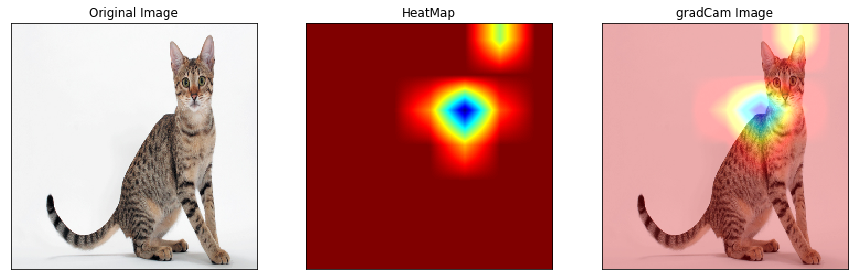

In [16]:
show_gradcam('cat1.jpg',model,layer_name='res5c_branch2b',label=285)

model predicted
 id= 837 
label=  'sunglasses, dark glasses, shades


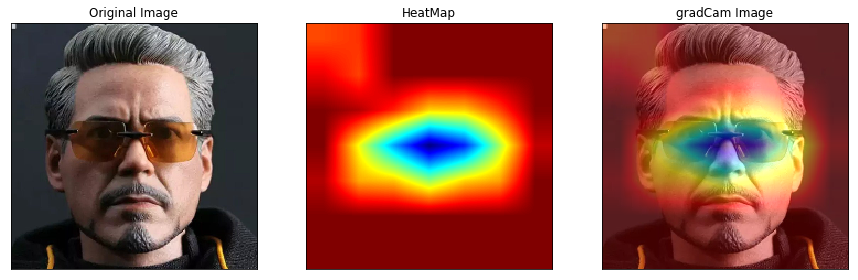

In [17]:
show_gradcam('glasses.jpg',model,layer_name='res5c_branch2b')

Visualizing 
id= 837 
label=  'sunglasses, dark glasses, shades 
on glasses.jpg


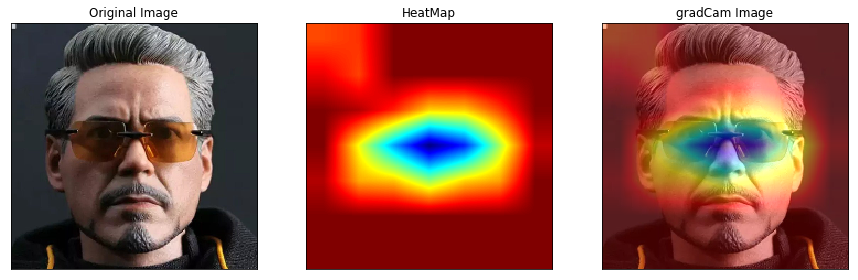

In [19]:
show_gradcam('glasses.jpg',model,layer_name='res5c_branch2b',label=837)

model predicted
 id= 254 
label=  'pug, pug-dog


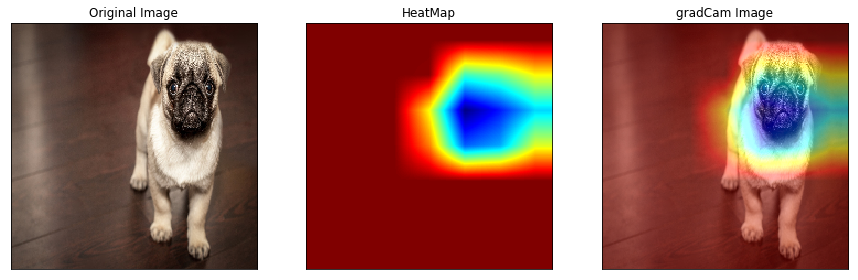

In [20]:
show_gradcam('pug-690566_1920.jpg',model,layer_name='res5c_branch2b')

Visualizing 
id= 254 
label=  'pug, pug-dog 
on pug-690566_1920.jpg


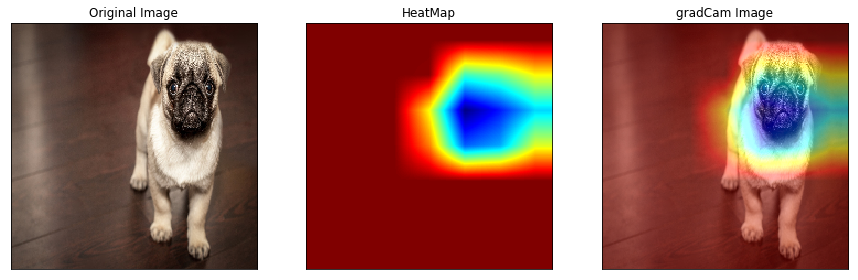

In [21]:
show_gradcam('pug-690566_1920.jpg',model,layer_name='res5c_branch2b',label=254)

Visualizing 
id= 837 
label=  'sunglasses, dark glasses, shades 
on pug-690566_1920.jpg


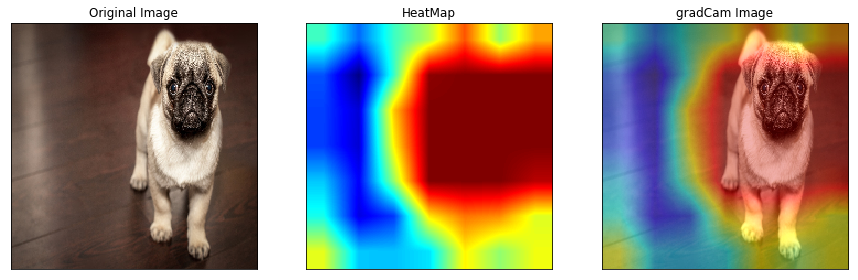

In [22]:
show_gradcam('pug-690566_1920.jpg',model,layer_name='res5c_branch2b',label=837)

Visualizing 
id= 837 
label=  'sunglasses, dark glasses, shades 
on cat1.jpg


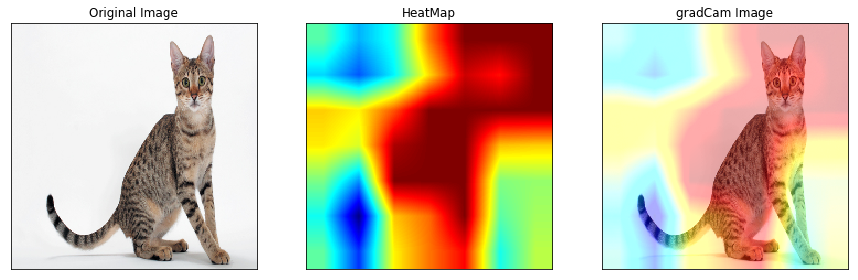

In [23]:
show_gradcam('cat1.jpg',model,layer_name='res5c_branch2b',label=837)

## Receptive Field calculations

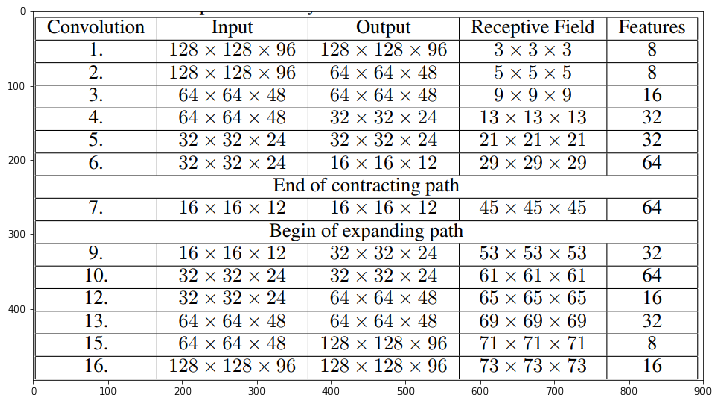

In [28]:
f = plt.figure(figsize=(12,12))

plt.imshow(io.imread('Assignment10_receptive_field.png'),)



---



---



---



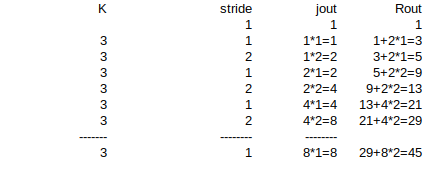



---In the figure above we can see that the filters are 3D ,our receptive field calculations (hence convolutions procedure )are same in both 2D and 3D,..Hence the receptive field increase will be same as the receptive filed increase it can be in 2D convolution...from 29 to 45 


(We had stride of 1 ,jump of 8 and kernel size =3 ,Hence `29 + (3-1)*8  =45 `)

